In [63]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math

import geopandas as gpd
from matplotlib.patches import Rectangle

In [64]:
my_cat_palette = sns.color_palette('Set2')
my_cont_palette = sns.color_palette('Blues')

sns.set_context('notebook')

In [65]:
data_folder = './data/'

file_air = data_folder + 'who_aap_2021_v9_11august2022.csv'
file_income = data_folder + 'who_country_income_ratings.csv'
countries_file = data_folder + 'countries of the world.csv'

In [66]:
who_air_data = pd.read_csv(file_air, sep=';', decimal=',')

who_region_income = pd.read_csv(file_income, sep=';')

**Now it's your turn!**

👉 **TODO 1.1:** Explore the data further to find interesting aspects/patterns to visualize. Once you've made some interesting discoveries, try to optimize the visualizations. For example, experiment with different chart types and improve the details of the chart(s). 

See the intro lecture and the lectures on visual language, chart-level design and component-level design for input and inspiration.

To get you started, here are some questions you could examine:
- What is the relationship between the wealth of a country/region and its air pollution?
- Which countries/regions have the lowest/highest pollution levels? For each pollution type?
- Which cities have the lowest/highest pollution levels? For each pollution type?
- How has pollution developed (in specific cities) over time?
- What is the relationship of population size / country size and pollution?
- etc.

In [67]:
# Firstly, let's print columns names to operate them later

print('Air Pollution columns: ', who_air_data.columns, '\n')
print('Wealthy columns: ', who_region_income.columns)

Air Pollution columns:  Index(['WHO Region', 'ISO3', 'WHO Country Name', 'City or Locality',
       'Measurement Year', 'PM2.5 (μg/m3)', 'PM10 (μg/m3)', 'NO2 (μg/m3)',
       'PM25 temporal coverage (%)', 'PM10 temporal coverage (%)',
       'NO2 temporal coverage (%)', 'Reference',
       'Number and type of monitoring stations', 'Version of the database'],
      dtype='object') 

Wealthy columns:  Index(['WHO Country Name', 'WHO Region', 'World Bank ranking of income 2019'], dtype='object')


In [68]:
# Join two tables = who_air_data LEFT OUTER JOIN who_region_income ON 'WHO Country Name' - columns 
air_data_income_df = pd.merge(left=who_air_data, 
                              right=who_region_income[['WHO Country Name', 'World Bank ranking of income 2019']],
                              on='WHO Country Name',
                              how='left')

### Let's answer the first question = 'What is the relationship between the wealth of a country/region and its air pollution?'

In [69]:
rank = 'World Bank ranking of income 2019'
# The information about income belongs to the year 2019, but the information about air pollutions covers:
print('Covered years: \n', sorted(list(air_data_income_df['Measurement Year'].unique())))

Covered years: 
 [2000, 2001, 2002, 2003, 2004, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021]


So, it probably makes sense to consider the period from 2017 - 2021 as the previous data in conjuction with income can be outdated. And we also can drop some columns which do not provide any information

In [70]:
year_from, year_to = 2017, 2021
indexes = (air_data_income_df['Measurement Year'] >= year_from) & (air_data_income_df['Measurement Year'] <= year_to)
df = air_data_income_df[indexes].drop(['Reference', 
                                        'Number and type of monitoring stations', 
                                        'Version of the database', 
                                        'City or Locality',
                                        'WHO Country Name', 
                                        'WHO Region', 
                                        'Measurement Year', 
                                        'PM25 temporal coverage (%)', 
                                        'PM10 temporal coverage (%)',
                                        'NO2 temporal coverage (%)'], axis=1)

# Now we can sum all the pollutions within each country and find the average value per year. Is the 0.0-value possible ??? 
# Let's consider that 0.0-value means 'No data' !!!
df = df.groupby(['ISO3', rank]).sum() / (year_to - year_from + 1)
df = df.reset_index()
df.head(3)

,ISO3,World Bank ranking of income 2019,PM2.5 (μg/m3),PM10 (μg/m3),NO2 (μg/m3)
0,AFG,low,23.954,0.000,0.00
1,ALB,upper middle,2.064,0.000,4.94
2,AND,high,0.000,14.816,17.26


Now let's plot distributions of the results using boxplot

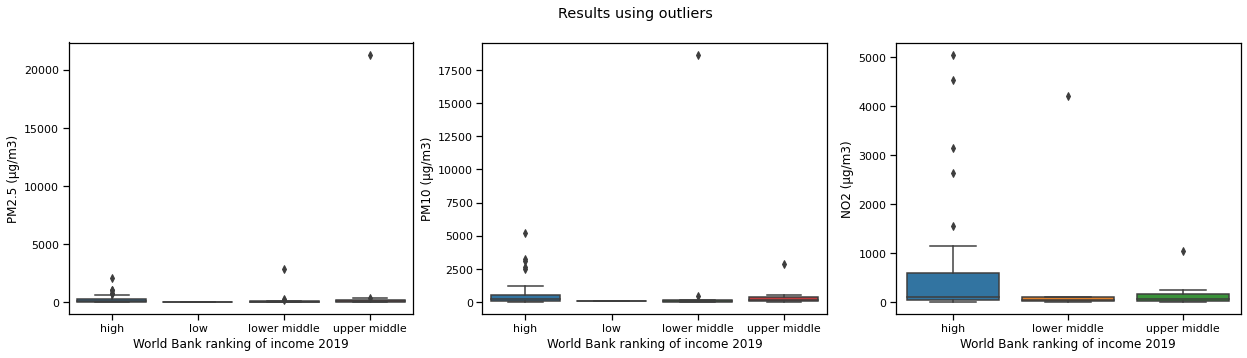

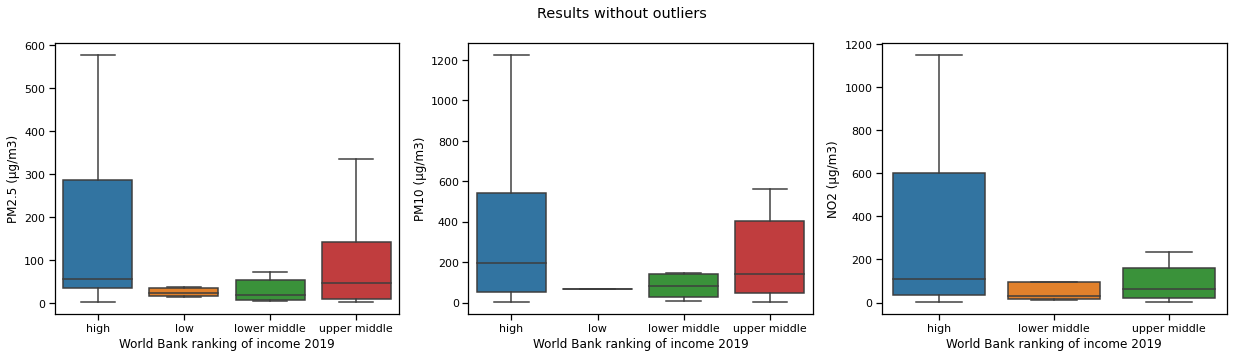

In [71]:
def box_plot(data, target, base, ax, outliers=True):
    frame = data[data[target] > 0.0]
    sns.boxplot(data=frame, x=base, y=target, showfliers=outliers, order=sorted(frame[base].unique()), ax=ax)

# with outliers
fig, axes = plt.subplots(1, 3, figsize=(21, 5))
fig.suptitle('Results using outliers')
box_plot(df, 'PM2.5 (μg/m3)', rank, axes[0])
box_plot(df, 'PM10 (μg/m3)', rank, axes[1])
box_plot(df, 'NO2 (μg/m3)', rank, axes[2])
plt.show()

# without outliers 
fig, axes = plt.subplots(1, 3, figsize=(21, 5))
fig.suptitle('Results without outliers')
box_plot(df, 'PM2.5 (μg/m3)', rank, axes[0], False)
box_plot(df, 'PM10 (μg/m3)', rank, axes[1], False)
box_plot(df, 'NO2 (μg/m3)', rank, axes[2], False)
plt.show()

From the visualization we can say that there is no data to analyze countries with low uncome (not enough data).
But from the plots with outliers we can see that each group has some countries which produce much more pollutions than most of the countries within the group

Finally, from boxplots without outliers we can suggest that there is a positive correlation between the level of pollutions and the level of income. Seems like wealthy contries produce more air pollutions.

Let's have a look on the outliers from boxplots.

### Which countries produce the largest / lowest of pollutions within each group ?

In [72]:
df = air_data_income_df[indexes].drop(['Reference', 
                                        'Number and type of monitoring stations', 
                                        'Version of the database', 
                                        'City or Locality',
                                        'WHO Country Name', 
                                        'WHO Region', 
                                        'Measurement Year', 
                                        'PM25 temporal coverage (%)', 
                                        'PM10 temporal coverage (%)',
                                        'NO2 temporal coverage (%)'], axis=1)

# Let's define the most "green" country as the one which produces the smalles amount of pollutions in general
targets = ['PM2.5 (μg/m3)', 'PM10 (μg/m3)', 'NO2 (μg/m3)']
df['Pollutions (μg/m3)'] = df[targets].sum(axis=1, numeric_only=True)

# Drop unnecessary information and countries with low income as their amount is too small
df = df[df[rank] != 'low'].drop(targets, axis=1)
df = df[df['Pollutions (μg/m3)'] > 0]

# Calculate average value and apply logarithm scale !!!
df = df.groupby(['ISO3', rank]).sum() / (year_to - year_from + 1)
df['Pollutions (μg/m3)'] = df['Pollutions (μg/m3)'].apply(np.log)
df = df.reset_index()

As we remember from boxplots with outliers, the difference between largest and lowest values can be very large !!!
So let's apply logarithm function to the pollutions !!!

In [73]:
def get_indexes(mlt_index):
    return list(map(lambda x: x[1], mlt_index))

# Calculate the highest and lowest
max_idx = get_indexes(df[df['Pollutions (μg/m3)'] > 0].groupby(rank)['Pollutions (μg/m3)'].nlargest(3).index)
min_idx = get_indexes(df[df['Pollutions (μg/m3)'] > 0].groupby(rank)['Pollutions (μg/m3)'].nsmallest(3).index)
others = list(set(df.index).difference(set(max_idx).union(set(min_idx))))

countries = dict(zip(who_air_data['ISO3'], who_air_data['WHO Country Name']))

Now let's show the results using scatterplot

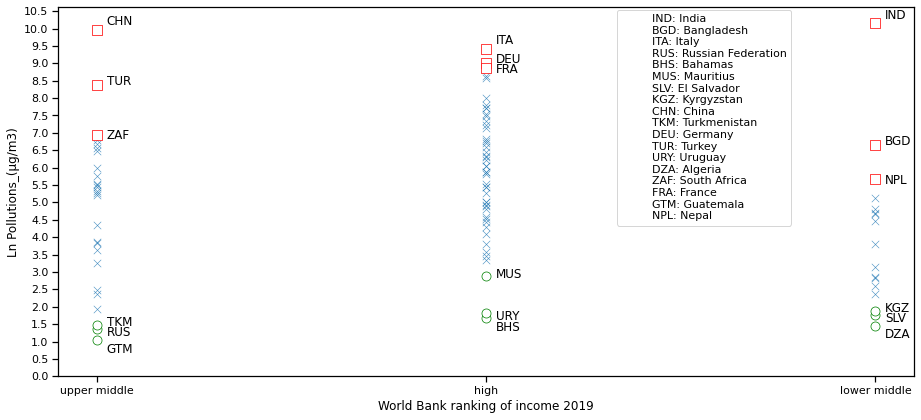

In [74]:
plt.figure(figsize=(13,6))
match_dict = dict(zip(sorted(df[rank].unique()), [1, 2, 0]))

# draw the values 
sns.scatterplot(data=df.loc[others], x=rank, y='Pollutions (μg/m3)', hue_order=sorted(df[rank].unique()), alpha=0.8, marker='x', s=55)
max_sct = sns.scatterplot(data=df.loc[max_idx], x=rank, y='Pollutions (μg/m3)', hue_order=sorted(df[rank].unique()),
                          marker='s', s=82, edgecolor='r', facecolor='white')

min_sct = sns.scatterplot(data=df.loc[min_idx], x=rank, y='Pollutions (μg/m3)', hue_order=sorted(df[rank].unique()), 
                          marker='o', s=82, edgecolor='g', facecolor='white')

# add annotations to points
shift, count = 0.13, 0
for elem in df.loc[max_idx].values:
    max_sct.annotate(elem[0], (elem[1], elem[2]), xytext=(match_dict[elem[1]] + 0.025, elem[2] + shift))
    count = (count + 1) % 3
    shift = 0.13 * (1 - count)

shift, count = 0.15, 0
for elem in df.loc[min_idx].values:
    min_sct.annotate(elem[0], (elem[1], elem[2]), xytext=(match_dict[elem[1]] + 0.025, elem[2] - shift - 0.2))
    count = (count + 1) % 3
    shift = 0.15 * (1 - count) 

# because of log-scale 
plt.yticks(np.arange(0, 11, 0.5))
plt.ylabel('Ln Pollutions_(μg/m3)')

# legend to identify countries
extra = Rectangle((0, 0), 1, 1, fc="w", fill=False, edgecolor='none', linewidth=0)
text = '\n'.join([ctr[0] + ': ' + countries[ctr[0]] for ctr in df.loc[set(max_idx).union(set(min_idx))].values])
plt.legend([extra], [text], bbox_to_anchor=(0.65, 1), loc=2, borderaxespad=0.2)

plt.tight_layout()
plt.show()

Using this scatter plot we can also notice that wealthy countries definitely produce more pollutions. The difference is visible even between lower and upper middle groups.

However, there are some countries which contaminate the air even worse than many othes (China, India, Italy, Germany, France). 
Scale is logarithmic !!!

We also can see from the scatterplot that many countries from upper middle and high groups having zeros between 5.0 and 7.0 on our scale. So let's consider countries from these two groups with respect to other factors (population and area)

### What is the relationship of population size / country size and pollution?

I found the following dataset which contains information about area and population density = https://www.kaggle.com/datasets/fernandol/countries-of-the-world

The interesting measurements are Population Density and GDP

In [75]:
countries = dict(zip(who_air_data['ISO3'], who_air_data['WHO Country Name']))
countries = pd.DataFrame(data={'WHO Country Name': list(countries.values()), 'ISO3': list(countries.keys())})
# copy in order to maitain actual version
tmp_df = df.copy()

In [76]:
df_world = pd.read_csv(countries_file)
# some additional handels
df_world['Country'] = df_world['Country'].apply(str.replace, args=(' ', ''))

df_world.head(2)

,Country,Region,Population,Area (sq. mi.),Pop. Density (per sq. mi.),Coastline (coast/area ratio),Net migration,Infant mortality (per 1000 births),GDP ($ per capita),Literacy (%),Phones (per 1000),Arable (%),Crops (%),Other (%),Climate,Birthrate,Deathrate,Agriculture,Industry,Service
0,Afghanistan,ASIA (EX. NEAR EAST),31056997,647500,"48,0","0,00","23,06","163,07",700.0,"36,0","3,2","12,13","0,22","87,65",1,"46,6","20,34","0,38","0,24","0,38"
1,Albania,EASTERN EUROPE,3581655,28748,"124,6","1,26","-4,93","21,52",4500.0,"86,5","71,2","21,09","4,42","74,49",3,"15,11","5,22","0,232","0,188","0,579"


In [88]:
target = 'Pollutions (μg/m3)'
# choose interesting data
df = tmp_df[tmp_df[rank].isin(['high', 'upper middle'])]

# join tables
df = pd.merge(left=df, right=countries, on='ISO3', how='left')
df = pd.merge(left=df, right=df_world[['Country', 'Pop. Density (per sq. mi.)', 
                                       'GDP ($ per capita)', 'Area (sq. mi.)', 'Population']], 
              left_on='WHO Country Name', right_on='Country', how='left')

# drop NAN
not_nan = ~df.isnull().any(axis=1)
df = df[not_nan]

In [89]:
# to numeric
df['Pop. Density (per sq. mi.)'] = df['Pop. Density (per sq. mi.)'].apply(lambda x: float(x.replace(',', '.')))

# apply log to get rid of big numbers
df['GDP ($ per capita)'] = df['GDP ($ per capita)'].apply(np.log)
df['Population'] = df['Population'].apply(np.log)
df['Area (sq. mi.)'] = df['Area (sq. mi.)'].apply(np.log)
df.head(2)

,ISO3,World Bank ranking of income 2019,Pollutions (μg/m3),WHO Country Name,Country,Pop. Density (per sq. mi.),GDP ($ per capita),Area (sq. mi.),Population
0,ALB,upper middle,1.946481,Albania,Albania,124.6,8.411833,10.266323,15.091336
1,AND,high,3.468108,Andorra,Andorra,152.1,9.852194,6.148468,11.173262


Let's consider counter plot like

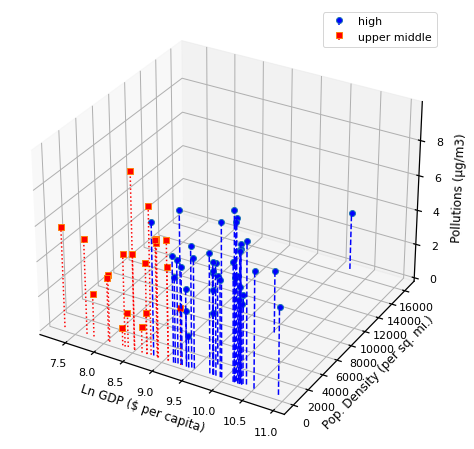

In [90]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(projection='3d')

idx = (df[rank] == 'high')
df_high, df_middle  = df[idx], df[~idx]


markerline, stemline, baseline = ax.stem(df_high['GDP ($ per capita)'], df_high['Pop. Density (per sq. mi.)'], 
                                         df_high[target], markerfmt='o', label='high')
markerline.set_markerfacecolor('blue')
stemline.set_linestyle('--')
stemline.set_edgecolor('blue')
baseline.set_color('none')

markerline, stemline, baseline = ax.stem(df_middle['GDP ($ per capita)'], df_middle['Pop. Density (per sq. mi.)'], 
                                         df_middle[target], markerfmt='s', label='upper middle')
markerline.set_markerfacecolor('red')
stemline.set_linestyle(':')
stemline.set_edgecolor('red')
baseline.set_color('none')

ax.set_xlabel('Ln GDP ($ per capita)')
ax.set_ylabel('Pop. Density (per sq. mi.)')
ax.set_zlabel(target)

plt.legend()
plt.show()

GDP values are different because of the income level. However, it seems like the population density does not influence the level of pollutions. 

However from the following scatter plot seems like there is a positive correlation between the size of a country and its population (values are logarithmic !!!). But we also can see, that the level of income influences pollutions more, as the countries with almost similar population and size produce the defferent pollution with respect to income

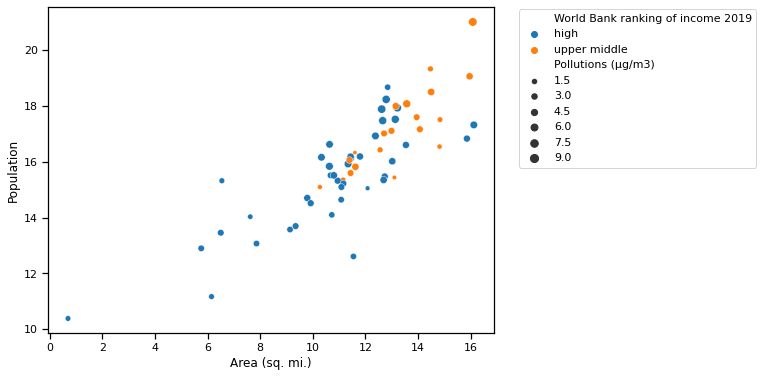

In [91]:
plt.figure(figsize=(8,6))

sns.scatterplot(data=df, x='Area (sq. mi.)', y='Population', hue=rank, 
                size=target, hue_order=sorted(df[rank].unique()))
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.2)
plt.show()

👉 **TODO 1.2:** Find another dataset and explore it as well (e.g. see the list of data sources at the top of this notebook). 

For inspiration, consider these prompts for what you could focus on here: 
- Can you tell a "data story" with 3-4 visualizations, plus connecting text explanations?
- Can you combine two datasets to allow for interesting new perspectives?
- Can you create an educational infovis example yourself? E.g. by showing the same data in 3-4 different chart types and discussing their pros and cons for this specific dataset.

Let's consider a dataset 'Air Passenger Satisfaction' (https://www.kaggle.com/datasets/teejmahal20/airline-passenger-satisfaction?resource=download&select=train.csv)

In [81]:
flights = data_folder + 'air_passenger_satisfaction.csv'
data = pd.read_csv(flights, index_col=0)
data = data.drop('id', axis=1)
data.head(2)

,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,...,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction
0,Male,Loyal Customer,13,Personal Travel,Eco Plus,460,3,4,3,1,...,5,4,3,4,4,5,5,25,18.0,neutral or dissatisfied
1,Male,disloyal Customer,25,Business travel,Business,235,3,2,3,3,...,1,1,5,3,1,4,1,1,6.0,neutral or dissatisfied


In [82]:
print(list(data.columns))
data.describe()

['Gender', 'Customer Type', 'Age', 'Type of Travel', 'Class', 'Flight Distance', 'Inflight wifi service', 'Departure/Arrival time convenient', 'Ease of Online booking', 'Gate location', 'Food and drink', 'Online boarding', 'Seat comfort', 'Inflight entertainment', 'On-board service', 'Leg room service', 'Baggage handling', 'Checkin service', 'Inflight service', 'Cleanliness', 'Departure Delay in Minutes', 'Arrival Delay in Minutes', 'satisfaction']


,Age,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,Food and drink,Online boarding,Seat comfort,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes
count,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103594.000000
mean,39.379706,1189.448375,2.729683,3.060296,2.756901,2.976883,3.202129,3.250375,3.439396,3.358158,3.382363,3.351055,3.631833,3.304290,3.640428,3.286351,14.815618,15.178678
std,15.114964,997.147281,1.327829,1.525075,1.398929,1.277621,1.329533,1.349509,1.319088,1.332991,1.288354,1.315605,1.180903,1.265396,1.175663,1.312273,38.230901,38.698682
min,7.000000,31.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,27.000000,414.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,3.000000,3.000000,3.000000,2.000000,0.000000,0.000000
50%,40.000000,843.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,4.000000,4.000000,4.000000,4.000000,4.000000,3.000000,4.000000,3.000000,0.000000,0.000000
75%,51.000000,1743.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,5.000000,4.000000,4.000000,4.000000,5.000000,4.000000,5.000000,4.000000,12.000000,13.000000
max,85.000000,4983.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,1592.000000,1584.000000


We can start from barplot which can tell the level of satisfaction within each class

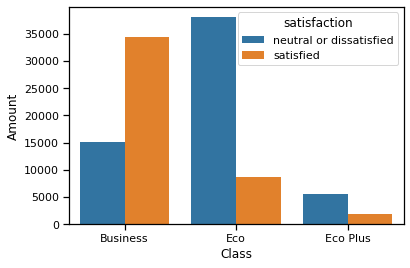

In [83]:
cols = ['Class', 'satisfaction', 'Age']
frequencies = data[cols].copy()

frequencies = frequencies.groupby(['Class', 'satisfaction']).count()
frequencies = frequencies.reset_index()
sns.barplot(data=frequencies, x='Class', y='Age', hue='satisfaction')

plt.ylabel('Amount')
plt.show()

So, we can see that usually clients who fly with Business Class are satisfied (almost 70%). Meanwhile the level of satisfaction in Eco and Eco Plus is very low.

Ok. Let's consider the age of clients. Are there any differences within classes ?

<Figure size 864x576 with 0 Axes>

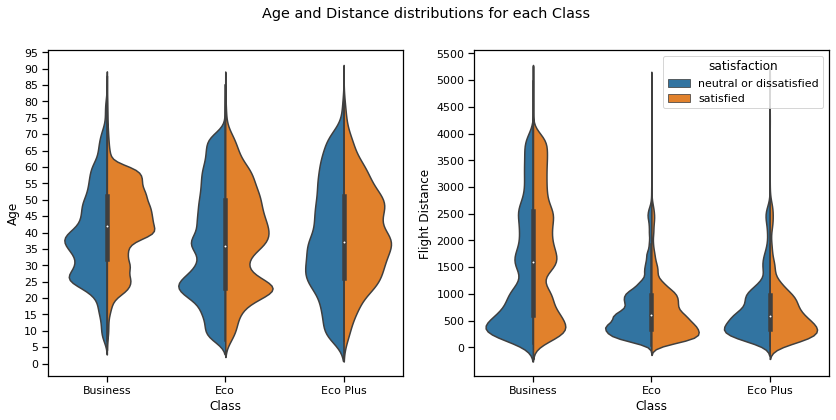

In [84]:
cols = ['Age', 'satisfaction', 'Class', 'Flight Distance']

age_df = data[cols].copy()


plt.figure(figsize=(12, 8))
fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(14,6))

sns.violinplot(data=age_df, x='Class', y='Age', hue='satisfaction', split=True, 
               order=sorted(age_df['Class'].unique()), ax=ax[0])
ax[0].set_yticks(np.arange(0, 100, 5))
ax[0].legend([], [], frameon=False)

sns.violinplot(data=age_df, x='Class', y='Flight Distance', hue='satisfaction', split=True, 
                       order=sorted(age_df['Class'].unique()), ax=ax[1])
ax[1].set_yticks(np.arange(0, 6000, 500))

fig.suptitle('Age and Distance distributions for each Class')
plt.show()

#### Business Class
This violin plot can work in conjunction with the previous barplot. Let's consider the satisfied clients who use business class. From the violin plot we can say that the distribution is a little shifted and people over 40 are more satisfied with business class while the clients up to 40 are neutral or dissatisfied
We also can notice that people prefer to fly with Business Class for long distances (2000 miles and more)

#### Eco and EcoPlus Class
Here the situation is quite equal. Eco and EcoPlus classes look alsmost simmetric but, as we remember, people are dissatisfied with these flights more often 

Let's explore the satisfaction with respect to age, flight distance and gender 

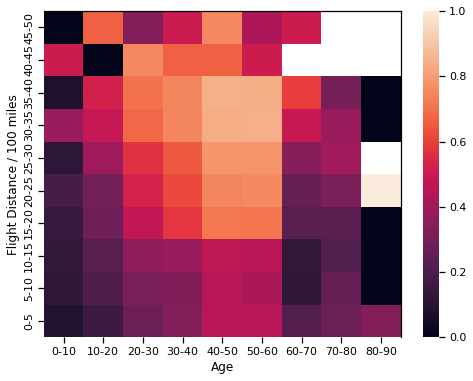

In [85]:
cols = ['Age', 'Flight Distance', 'satisfaction']

df = data[cols].copy()

df['satisfaction'] = df['satisfaction'].apply(lambda x: 1 if x == 'satisfied' else 0)
df['Age'] = df['Age'].apply(lambda x: math.ceil(x / 10) * 10)
df['Flight Distance'] = df['Flight Distance'].apply(lambda x: math.ceil(x / 500) * 500)

pivot = pd.pivot_table(data=df, index='Flight Distance', columns='Age', 
                       values='satisfaction', aggfunc=np.mean)

plt.figure(figsize=(8, 6))
ax = sns.heatmap(pivot)
ax.invert_yaxis()
ax.set_ylabel('Flight Distance / 100 miles')
ax.spines['right'].set(visible=True)
ax.spines['top'].set(visible=True)

ax.set_xticklabels([str(10 * i) + '-' + str(10 * (i + 1)) for i in range(9)])
ax.set_yticklabels([str(i) + '-' + str(i + 5) for i in range(0, 50, 5)])
plt.show()

Here we can see thath the most satisfied feedback people aged from 30 to 60 with flight distances over 1500 miles.